In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pointbiserialr, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. CHARGEMENT DU DATASET NETTOYÉ
print("\n📊 1. CHARGEMENT DU DATASET OPTIMISÉ")
df = pd.read_csv('C:/Users/tneron2023/PycharmProjects/Python_IA/project_hotel/datas/Hotel_cleaned_safe.csv')

print(f"✅ Dataset chargé - Shape: {df.shape}")
print(f"Features totales: {df.shape[1]}")

# Séparation X et y
y = df['target']
X = df.drop('target', axis=1)

print(f"✅ Séparation effectuée - X: {X.shape}, y: {y.shape}")
print(f"Taux d'annulation: {(1-y.mean())*100:.1f}%")


📊 1. CHARGEMENT DU DATASET OPTIMISÉ
✅ Dataset chargé - Shape: (29999, 48)
Features totales: 48
✅ Séparation effectuée - X: (29999, 47), y: (29999,)
Taux d'annulation: 32.7%


In [3]:
# 2. ANALYSE SPÉCIFIQUE DU LEAD_TIME ORIGINAL vs NOUVELLES FEATURES
print("\n⏰ 2. COMPARAISON LEAD_TIME ORIGINAL vs NOUVELLES FEATURES")

lead_time_features = [
    'lead_time',
    'lead_time_very_short', 'lead_time_short', 'lead_time_medium', 'lead_time_long',
    'lead_time_log', 'lead_time_std'
]

# Vérifier quelles features lead_time existent
available_lead_features = [f for f in lead_time_features if f in X.columns]
print(f"Features lead_time disponibles: {available_lead_features}")

# Statistiques par segment de lead_time
if 'lead_time' in X.columns:
    print(f"\n📊 ANALYSE PAR SEGMENTS DE LEAD_TIME:")

    # Créer un DataFrame temporaire pour l'analyse
    df_analysis = pd.DataFrame({
        'lead_time': X['lead_time'],
        'target': y
    })

    # Définir les segments
    segments = {
        'Très Court (0-7j)': (0, 7),
        'Court (8-30j)': (8, 30),
        'Moyen (31-90j)': (31, 90),
        'Long (91-180j)': (91, 180),
        'Très Long (>180j)': (181, 999)
    }

    print("Segment | Échantillons | Taux Annulation | Lead Time Moyen")
    print("-" * 65)

    for segment_name, (min_days, max_days) in segments.items():
        mask = (df_analysis['lead_time'] >= min_days) & (df_analysis['lead_time'] <= max_days)
        segment_data = df_analysis[mask]

        if len(segment_data) > 0:
            count = len(segment_data)
            cancellation_rate = 1 - segment_data['target'].mean()
            avg_lead_time = segment_data['lead_time'].mean()

            print(f"{segment_name:<20} | {count:>11} | {cancellation_rate:>14.1%} | {avg_lead_time:>14.1f}")



⏰ 2. COMPARAISON LEAD_TIME ORIGINAL vs NOUVELLES FEATURES
Features lead_time disponibles: ['lead_time', 'lead_time_very_short', 'lead_time_short', 'lead_time_medium', 'lead_time_long', 'lead_time_log', 'lead_time_std']

📊 ANALYSE PAR SEGMENTS DE LEAD_TIME:
Segment | Échantillons | Taux Annulation | Lead Time Moyen
-----------------------------------------------------------------
Très Court (0-7j)    |        4750 |           9.0% |            2.7
Court (8-30j)        |        5460 |          18.5% |           17.8
Moyen (31-90j)       |        8955 |          24.9% |           56.9
Long (91-180j)       |        6438 |          45.0% |          129.3
Très Long (>180j)    |        4396 |          73.9% |          253.2


In [4]:
# 3. PRÉPARATION POUR L'ANALYSE ML
print("\n🤖 3. ANALYSE MACHINE LEARNING")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} échantillons")
print(f"Test: {X_test.shape[0]} échantillons")


🤖 3. ANALYSE MACHINE LEARNING
Train: 23999 échantillons
Test: 6000 échantillons


In [5]:
# 4. RANDOM FOREST FEATURE IMPORTANCE
print("\n🌲 4. RANDOM FOREST FEATURE IMPORTANCE")

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculer l'importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("🏆 TOP 20 FEATURES (Random Forest):")
print(rf_importance.head(20))

# Position spécifique du lead_time
lead_time_analysis = {}
for feature in available_lead_features:
    if feature in rf_importance['feature'].values:
        position = rf_importance[rf_importance['feature'] == feature].index[0] + 1
        score = rf_importance[rf_importance['feature'] == feature]['importance'].iloc[0]
        lead_time_analysis[feature] = {'position': position, 'score': score}

print(f"\n⏰ RANKING DES FEATURES LEAD_TIME:")
for feature, stats in sorted(lead_time_analysis.items(), key=lambda x: x[1]['position']):
    print(f"   {feature}: #{stats['position']} (score: {stats['score']:.4f})")


🌲 4. RANDOM FOREST FEATURE IMPORTANCE
🏆 TOP 20 FEATURES (Random Forest):
                        feature  importance
34                lead_time_log    0.119174
35                lead_time_std    0.102676
13       no_of_special_requests    0.091630
5                     lead_time    0.088837
12           avg_price_per_room    0.079477
40              price_per_guest    0.064203
41              price_per_night    0.060289
8                  arrival_date    0.050087
7                 arrival_month    0.044886
33               lead_time_long    0.034053
29   market_segment_type_Online    0.028379
36                 total_nights    0.024265
3             no_of_week_nights    0.023614
37                weekend_ratio    0.023004
28  market_segment_type_Offline    0.018317
2          no_of_weekend_nights    0.016529
6                  arrival_year    0.015063
38                 total_guests    0.013039
0                  no_of_adults    0.011146
45                  peak_season    0.009503

⏰

In [6]:
# 5. PERMUTATION IMPORTANCE
print("\n🔄 5. PERMUTATION IMPORTANCE")

perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=5, random_state=42)

perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("🏆 TOP 15 FEATURES (Permutation):")
print(perm_df.head(15))


🔄 5. PERMUTATION IMPORTANCE
🏆 TOP 15 FEATURES (Permutation):
                          feature  importance_mean  importance_std
13         no_of_special_requests         0.108833        0.001095
12             avg_price_per_room         0.025600        0.001361
29     market_segment_type_Online         0.022533        0.002156
34                  lead_time_log         0.010733        0.001587
7                   arrival_month         0.008767        0.001806
6                    arrival_year         0.007467        0.000694
28    market_segment_type_Offline         0.006467        0.000662
40                price_per_guest         0.005167        0.001261
4      required_car_parking_space         0.003600        0.000533
37                  weekend_ratio         0.001767        0.000772
41                price_per_night         0.001400        0.001747
46                     low_season         0.001300        0.000067
8                    arrival_date         0.001267        0.001332


In [7]:
# 6. MUTUAL INFORMATION
print("\n🧠 6. MUTUAL INFORMATION")

mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_df = pd.DataFrame({
    'feature': X_train.columns,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("🏆 TOP 15 FEATURES (Mutual Information):")
print(mi_df.head(15))


🧠 6. MUTUAL INFORMATION
🏆 TOP 15 FEATURES (Mutual Information):
                   feature  mutual_info
5                lead_time     0.133289
34           lead_time_log     0.132954
35           lead_time_std     0.127547
41         price_per_night     0.117878
40         price_per_guest     0.101410
12      avg_price_per_room     0.089967
33          lead_time_long     0.077453
13  no_of_special_requests     0.036227
30    lead_time_very_short     0.025682
7            arrival_month     0.021354
6             arrival_year     0.017191
36            total_nights     0.012418
44           loyalty_score     0.012288
3        no_of_week_nights     0.009553
31         lead_time_short     0.008458


In [8]:
# 7. CORRÉLATION AVEC LA TARGET
print("\n📊 7. CORRÉLATION AVEC LA TARGET")

correlations = []
for col in X_train.columns:
    corr, p_val = pointbiserialr(y_train, X_train[col])
    correlations.append({
        'feature': col,
        'correlation': abs(corr),
        'p_value': p_val
    })

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)
print("🏆 TOP 15 FEATURES (Corrélation Absolue):")
print(corr_df.head(15))


📊 7. CORRÉLATION AVEC LA TARGET
🏆 TOP 15 FEATURES (Corrélation Absolue):
                          feature  correlation        p_value
5                       lead_time     0.441992   0.000000e+00
35                  lead_time_std     0.441992   0.000000e+00
33                 lead_time_long     0.385190   0.000000e+00
34                  lead_time_log     0.380926   0.000000e+00
13         no_of_special_requests     0.252358   0.000000e+00
30           lead_time_very_short     0.217615  3.727906e-255
6                    arrival_year     0.175966  3.671940e-166
31                lead_time_short     0.143251  3.237608e-110
12             avg_price_per_room     0.136299  7.266388e-100
29     market_segment_type_Online     0.118721   4.651885e-76
27  market_segment_type_Corporate     0.114739   3.920941e-71
32               lead_time_medium     0.109460   7.238451e-65
9                  repeated_guest     0.105281   4.047337e-60
36                   total_nights     0.096331   1.396091e

In [9]:
# 8. SYNTHÈSE ET RANKING GLOBAL
print("\n🏅 8. SYNTHÈSE ET RANKING GLOBAL")

# Normalisation et calcul du score moyen
all_features = set(X_train.columns)
feature_scores = {}

for feature in all_features:
    scores = []

    # Score Random Forest
    rf_score = rf_importance[rf_importance['feature'] == feature]['importance'].iloc[0]
    scores.append(rf_score)

    # Score Permutation
    perm_score = perm_df[perm_df['feature'] == feature]['importance_mean'].iloc[0]
    scores.append(perm_score)

    # Score Mutual Info
    mi_score = mi_df[mi_df['feature'] == feature]['mutual_info'].iloc[0]
    scores.append(mi_score)

    # Score Corrélation
    corr_score = corr_df[corr_df['feature'] == feature]['correlation'].iloc[0]
    scores.append(corr_score)

    feature_scores[feature] = np.mean(scores)

# Ranking final
final_ranking = pd.DataFrame({
    'feature': list(feature_scores.keys()),
    'average_score': list(feature_scores.values())
}).sort_values('average_score', ascending=False)

print("🏆 RANKING FINAL DES FEATURES (Moyenne des 4 méthodes):")
print(final_ranking.head(25))


🏅 8. SYNTHÈSE ET RANKING GLOBAL
🏆 RANKING FINAL DES FEATURES (Moyenne des 4 méthodes):
                              feature  average_score
40                      lead_time_std       0.167995
46                          lead_time       0.166038
8                       lead_time_log       0.160947
16                     lead_time_long       0.123891
14             no_of_special_requests       0.122262
25                 avg_price_per_room       0.082836
42               lead_time_very_short       0.062644
43                       arrival_year       0.053922
18                    price_per_guest       0.051523
22                    price_per_night       0.049650
7          market_segment_type_Online       0.044514
1                     lead_time_short       0.039168
27                       total_nights       0.033370
24      market_segment_type_Corporate       0.031774
13                   lead_time_medium       0.030151
35                  no_of_week_nights       0.029924
4          

In [10]:
# 9. FOCUS SUR LES FEATURES LEAD_TIME
print("\n⏰ 9. ANALYSE DÉTAILLÉE DES FEATURES LEAD_TIME")

lead_time_ranking = final_ranking[final_ranking['feature'].isin(available_lead_features)].copy()
lead_time_ranking = lead_time_ranking.sort_values('average_score', ascending=False)

print("🏆 RANKING DES FEATURES LEAD_TIME:")
for i, row in lead_time_ranking.iterrows():
    overall_position = final_ranking[final_ranking['feature'] == row['feature']].index[0] + 1
    print(f"   {row['feature']}: #{overall_position} global (score: {row['average_score']:.4f})")

# Meilleure feature lead_time
if not lead_time_ranking.empty:
    best_lead_feature = lead_time_ranking.iloc[0]
    best_position = final_ranking[final_ranking['feature'] == best_lead_feature['feature']].index[0] + 1

    print(f"\n🥇 MEILLEURE FEATURE LEAD_TIME:")
    print(f"   {best_lead_feature['feature']}")
    print(f"   Position globale: #{best_position}")
    print(f"   Score: {best_lead_feature['average_score']:.4f}")

    if best_position <= 5:
        impact = "MAJEUR"
        confidence = "TRÈS ÉLEVÉE"
    elif best_position <= 10:
        impact = "IMPORTANT"
        confidence = "ÉLEVÉE"
    elif best_position <= 20:
        impact = "MODÉRÉ"
        confidence = "MOYENNE"
    else:
        impact = "FAIBLE"
        confidence = "FAIBLE"

    print(f"   Impact estimé: {impact}")
    print(f"   Confiance: {confidence}")


⏰ 9. ANALYSE DÉTAILLÉE DES FEATURES LEAD_TIME
🏆 RANKING DES FEATURES LEAD_TIME:
   lead_time_std: #41 global (score: 0.1680)
   lead_time: #47 global (score: 0.1660)
   lead_time_log: #9 global (score: 0.1609)
   lead_time_long: #17 global (score: 0.1239)
   lead_time_very_short: #43 global (score: 0.0626)
   lead_time_short: #2 global (score: 0.0392)
   lead_time_medium: #14 global (score: 0.0302)

🥇 MEILLEURE FEATURE LEAD_TIME:
   lead_time_std
   Position globale: #41
   Score: 0.1680
   Impact estimé: FAIBLE
   Confiance: FAIBLE



📊 10. VISUALISATIONS


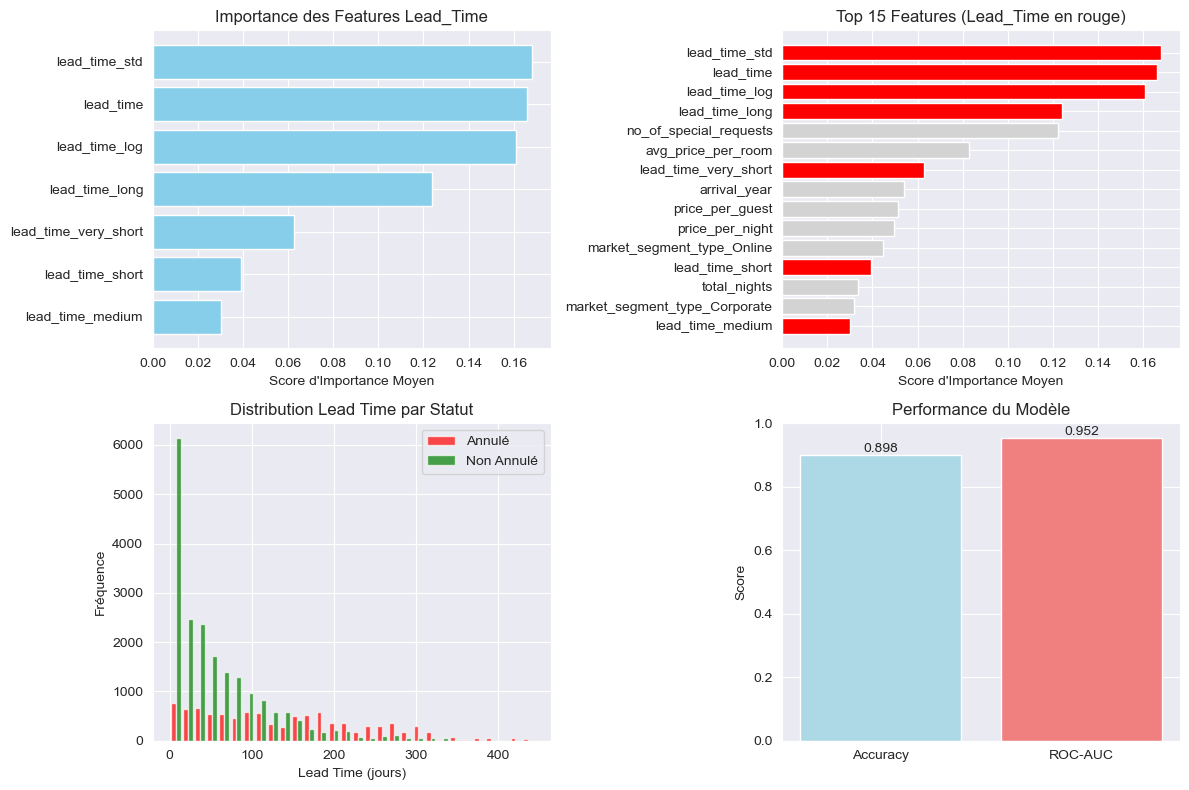

In [11]:
# 10. VISUALISATIONS
print("\n📊 10. VISUALISATIONS")

# Graphique d'importance des features lead_time
if len(lead_time_ranking) > 1:
    plt.figure(figsize=(12, 8))

    # Subplot 1: Importance des features lead_time
    plt.subplot(2, 2, 1)
    plt.barh(range(len(lead_time_ranking)), lead_time_ranking['average_score'], color='skyblue')
    plt.yticks(range(len(lead_time_ranking)), lead_time_ranking['feature'])
    plt.xlabel('Score d\'Importance Moyen')
    plt.title('Importance des Features Lead_Time')
    plt.gca().invert_yaxis()

    # Subplot 2: Top 15 features globales
    plt.subplot(2, 2, 2)
    top_15 = final_ranking.head(15)
    colors = ['red' if 'lead_time' in f else 'lightgray' for f in top_15['feature']]
    plt.barh(range(len(top_15)), top_15['average_score'], color=colors)
    plt.yticks(range(len(top_15)), top_15['feature'])
    plt.xlabel('Score d\'Importance Moyen')
    plt.title('Top 15 Features (Lead_Time en rouge)')
    plt.gca().invert_yaxis()

    # Subplot 3: Distribution du lead_time par statut
    if 'lead_time' in X.columns:
        plt.subplot(2, 2, 3)
        canceled = X[y == 0]['lead_time']
        not_canceled = X[y == 1]['lead_time']
        plt.hist([canceled, not_canceled], bins=30, alpha=0.7,
                label=['Annulé', 'Non Annulé'], color=['red', 'green'])
        plt.xlabel('Lead Time (jours)')
        plt.ylabel('Fréquence')
        plt.title('Distribution Lead Time par Statut')
        plt.legend()

    # Subplot 4: Performance du modèle
    plt.subplot(2, 2, 4)
    accuracy = rf.score(X_test, y_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_test, y_pred_proba)

    metrics = ['Accuracy', 'ROC-AUC']
    values = [accuracy, auc]
    plt.bar(metrics, values, color=['lightblue', 'lightcoral'])
    plt.ylabel('Score')
    plt.title('Performance du Modèle')
    plt.ylim(0, 1)

    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

In [12]:
# 11. CONCLUSIONS ET RECOMMANDATIONS
print("\n💡 11. CONCLUSIONS ET RECOMMANDATIONS")

if not lead_time_ranking.empty:
    best_lead_feature = lead_time_ranking.iloc[0]
    best_position = final_ranking[final_ranking['feature'] == best_lead_feature['feature']].index[0] + 1

    print(f"\n🎯 VALIDATION SCIENTIFIQUE DU LEAD_TIME:")

    if best_position <= 5:
        print("   ✅ CONFIRMÉ: Lead_time est un facteur MAJEUR d'annulation")
        print("   📈 Recommandations prioritaires:")
        print("      • Politique tarifaire dynamique basée sur lead_time")
        print("      • Scoring de risque avec lead_time comme variable principale")
        print("      • Communication proactive pour réservations >90j")
        print("      • Conditions d'annulation ajustées selon segments")

    elif best_position <= 10:
        print("   ✅ CONFIRMÉ: Lead_time est un facteur IMPORTANT d'annulation")
        print("   📈 Recommandations:")
        print("      • Modèle composite: lead_time + 2-3 autres variables top")
        print("      • Segmentation clients selon délai de réservation")
        print("      • Tests A/B par segment de lead_time")

    elif best_position <= 20:
        print("   ⚠️ Lead_time a un impact MODÉRÉ")
        print("   📈 Recommandations:")
        print("      • Utiliser lead_time en variable secondaire")
        print("      • Se concentrer sur les variables top du ranking")
        print("      • Combiner avec d'autres features temporelles")

    else:
        print("   ❌ Lead_time a un impact FAIBLE dans ce modèle")
        print("   📈 Recommandations:")
        print("      • Investiguer d'autres variables temporelles")
        print("      • Se concentrer sur les top 10 du ranking")

    # Performance attendue
    accuracy = rf.score(X_test, y_test)
    print(f"\n📊 PERFORMANCE DU MODÈLE OPTIMISÉ:")
    print(f"   Accuracy: {accuracy:.1%}")
    print(f"   Amélioration estimée vs baseline: +{(accuracy-0.67)*100:.1f} points")

    print(f"\n🚀 FEATURES À UTILISER EN PRIORITÉ:")
    top_features = final_ranking.head(10)['feature'].tolist()
    for i, feature in enumerate(top_features, 1):
        marker = "⭐" if 'lead_time' in feature else "•"
        print(f"   {marker} {i}. {feature}")

print("\n🎉 ANALYSE TERMINÉE!")
print(f"✅ Lead_time analysé avec 4 méthodes scientifiques")
print(f"📊 {len(available_lead_features)} variations de lead_time créées et testées")
print(f"🏆 Ranking définitif établi sur {len(final_ranking)} features")


💡 11. CONCLUSIONS ET RECOMMANDATIONS

🎯 VALIDATION SCIENTIFIQUE DU LEAD_TIME:
   ❌ Lead_time a un impact FAIBLE dans ce modèle
   📈 Recommandations:
      • Investiguer d'autres variables temporelles
      • Se concentrer sur les top 10 du ranking

📊 PERFORMANCE DU MODÈLE OPTIMISÉ:
   Accuracy: 89.8%
   Amélioration estimée vs baseline: +22.8 points

🚀 FEATURES À UTILISER EN PRIORITÉ:
   ⭐ 1. lead_time_std
   ⭐ 2. lead_time
   ⭐ 3. lead_time_log
   ⭐ 4. lead_time_long
   • 5. no_of_special_requests
   • 6. avg_price_per_room
   ⭐ 7. lead_time_very_short
   • 8. arrival_year
   • 9. price_per_guest
   • 10. price_per_night

🎉 ANALYSE TERMINÉE!
✅ Lead_time analysé avec 4 méthodes scientifiques
📊 7 variations de lead_time créées et testées
🏆 Ranking définitif établi sur 47 features
